#  Transparent Insight: Exploring XAI with ResNets for Brain and Kidney Imaging Analysis


##### Sare Naz Bayraktutan
##### Tuncer Sivri



In this project, we propose to explore eXplainable Artificial Intelligence (XAI) techniques using ResNet models on brain and kidney datasets. XAI methods such as SHAP (SHapley Additive exPlanations), LIME (Local Interpretable Model-agnostic Explanations), and GradCAM (Gradient-weighted Class Activation Mapping) will be employed to interpret and understand the model's decisions. The goal is to gain insights into how models operate on medical imaging datasets and to compare the interpretability and performance of different XAI techniques.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)
[Data Preparation](#data_preparation)
[Modeling and Evaluation](#modeling_and_evaluation)   
[SHAP Part](#SHAP_part)   
[LIME Part](#LIME_part)   
[GRAD-CAM Part](#GRAD-CAM_part)   
[Further Analysis](#further_analysis)   
[References](#references)   


In [ ]:
# Required installs

In [ ]:
pip install shap

In [ ]:
pip install lime

In [ ]:
pip install tf_keras_vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.1 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.preprocessing.image import save_img
import os
from PIL import Image
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import warnings
warnings.filterwarnings(action="ignore")
%matplotlib inline
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm  # For progress bar
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import shap
from tensorflow.keras.applications.resnet50 import preprocess_input
import random
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionResNetV2
import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Problem <a class="anchor" id="problem"></a>



The problem is trying to understand which parts of the images are influencing the model's predictions the most.

#### Data Understanding <a class="anchor" id="data_understanding"></a>

In [ ]:

glioma_train = ['/content/drive/MyDrive/brain/Training/glioma_tumor']

no_tumors_train = ['/content/drive/MyDrive/brain/Training/no_tumor']

meningioma_train = ['/content/drive/MyDrive/brain/Training/meningioma_tumor']

pituitary_train = ['/content/drive/MyDrive/brain/Training/pituitary_tumor']

glioma_test = ['/content/drive/MyDrive/brain/Testing/glioma_tumor']

no_tumors_test = ['/content/drive/MyDrive/brain/Testing/no_tumor']

meningioma_test = ['/content/drive/MyDrive/brain/Testing/meningioma_tumor']

pituitary_test = ['/content/drive/MyDrive/brain/Testing/pituitary_tumor']

filepaths_train = []
labels_train = []
filepaths_test = []
labels_test = []
dict_lists_train = [glioma_train, no_tumors_train, meningioma_train, pituitary_train]
dict_lists_test = [glioma_test, no_tumors_test, meningioma_test, pituitary_test]

class_labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
for i, dir_list in enumerate(dict_lists_train):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths_train.append(fpath)
            labels_train.append(class_labels[i])

Fseries_train = pd.Series(filepaths_train, name="filepaths")
Lseries_train = pd.Series(labels_train, name="labels")
BRAIN_data_train = pd.concat([Fseries_train, Lseries_train], axis=1)
BRAIN_df_train = pd.DataFrame(BRAIN_data_train)
print(BRAIN_df_train.head())
print(BRAIN_df_train["labels"].value_counts())


for i, dir_list in enumerate(dict_lists_test):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths_test.append(fpath)
            labels_test.append(class_labels[i])

Fseries_test = pd.Series(filepaths_test, name="filepaths")
Lseries_test = pd.Series(labels_test, name="labels")
BRAIN_data_test = pd.concat([Fseries_test, Lseries_test], axis=1)
BRAIN_df_test = pd.DataFrame(BRAIN_data_test)
print(BRAIN_df_test.head())
print(BRAIN_df_test["labels"].value_counts())

                                           filepaths        labels
0  /content/drive/MyDrive/brain/Training/glioma_t...  glioma_tumor
1  /content/drive/MyDrive/brain/Training/glioma_t...  glioma_tumor
2  /content/drive/MyDrive/brain/Training/glioma_t...  glioma_tumor
3  /content/drive/MyDrive/brain/Training/glioma_t...  glioma_tumor
4  /content/drive/MyDrive/brain/Training/glioma_t...  glioma_tumor
labels
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64
                                           filepaths        labels
0  /content/drive/MyDrive/brain/Testing/glioma_tu...  glioma_tumor
1  /content/drive/MyDrive/brain/Testing/glioma_tu...  glioma_tumor
2  /content/drive/MyDrive/brain/Testing/glioma_tu...  glioma_tumor
3  /content/drive/MyDrive/brain/Testing/glioma_tu...  glioma_tumor
4  /content/drive/MyDrive/brain/Testing/glioma_tu...  glioma_tumor
labels
meningioma_tumor    115
no_tumor            105
glioma_tumor

In [ ]:
BRAIN_df_train

filepaths           labels
0     /content/drive/MyDrive/brain/Training/glioma_t...     glioma_tumor
1     /content/drive/MyDrive/brain/Training/glioma_t...     glioma_tumor
2     /content/drive/MyDrive/brain/Training/glioma_t...     glioma_tumor
3     /content/drive/MyDrive/brain/Training/glioma_t...     glioma_tumor
4     /content/drive/MyDrive/brain/Training/glioma_t...     glioma_tumor
...                                                 ...              ...
2865  /content/drive/MyDrive/brain/Training/pituitar...  pituitary_tumor
2866  /content/drive/MyDrive/brain/Training/pituitar...  pituitary_tumor
2867  /content/drive/MyDrive/brain/Training/pituitar...  pituitary_tumor
2868  /content/drive/MyDrive/brain/Training/pituitar...  pituitary_tumor
2869  /content/drive/MyDrive/brain/Training/pituitar...  pituitary_tumor

[2870 rows x 2 columns]

In [ ]:
BRAIN_df = pd.concat([BRAIN_df_train, BRAIN_df_test], ignore_index=True)

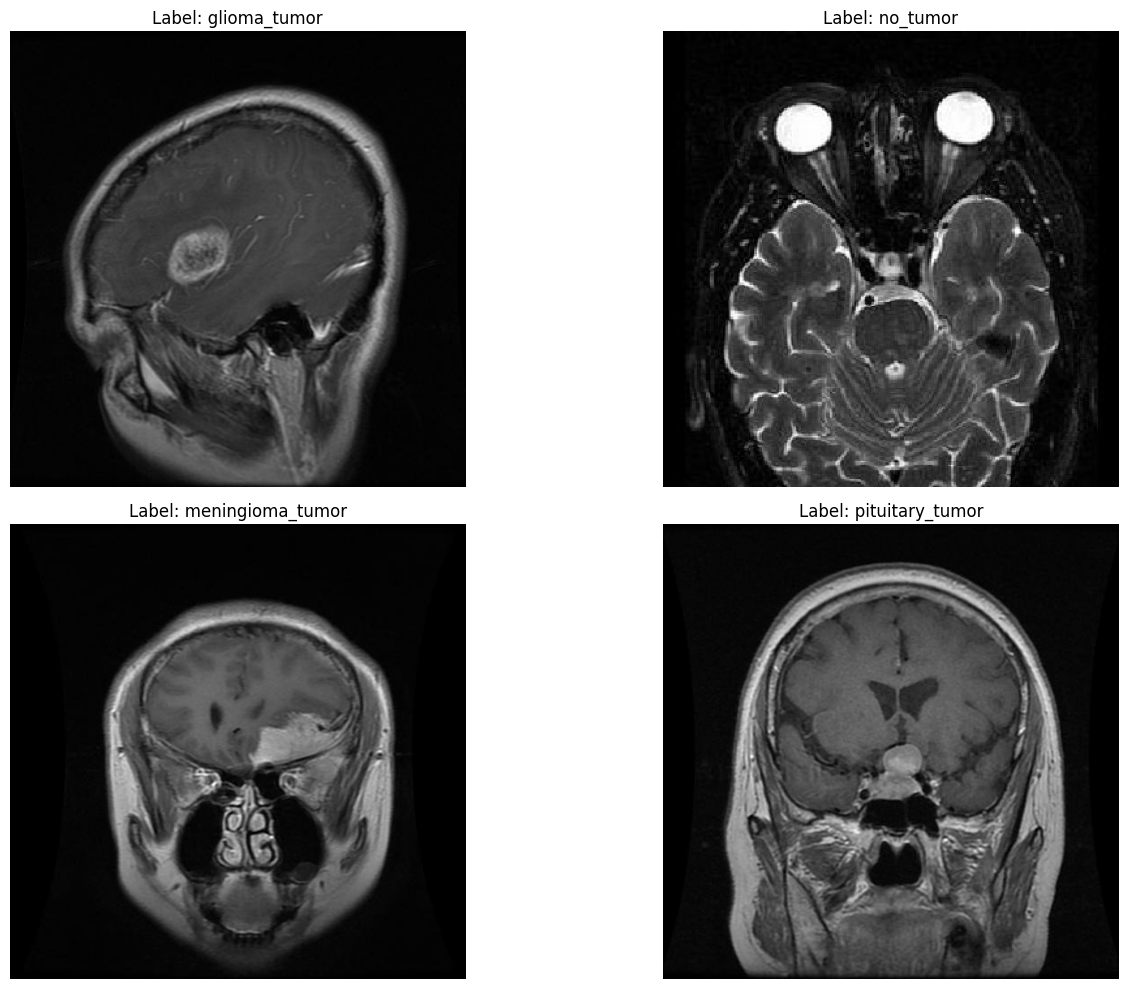

In [ ]:
# Set the size of the plot
plt.figure(figsize=(15, 10))

for i, label in enumerate(class_labels):
    # Find the first occurrence of the label in the DataFrame
    sample_row = BRAIN_df[BRAIN_df['labels'] == label].iloc[0]

    # Load the image
    image_path = sample_row['filepaths']
    image = Image.open(image_path)

    # Display the image with its label
    plt.subplot(2, 2, i+1)  # Arrange plots in 2x2 grid
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')  # Turn off the axis

plt.tight_layout()
plt.show()

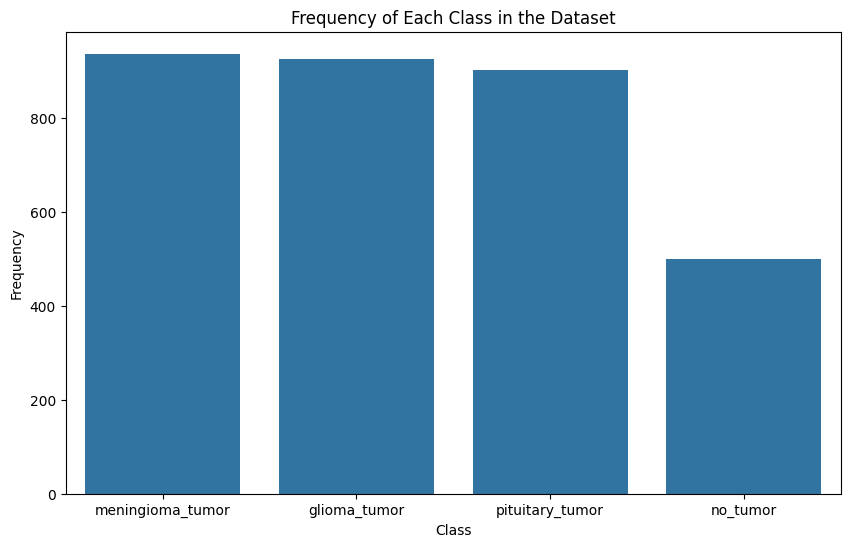

In [ ]:
# Get the frequency of each label
label_counts = BRAIN_df['labels'].value_counts()

# Plot the frequency table
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Frequency of Each Class in the Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


In [ ]:
def analyze_image_properties(image_paths, label):
    sizes = []
    modes = []

    for path in image_paths:
        with Image.open(path) as img:
            sizes.append(img.size)  # Get image size (width, height)
            modes.append(img.mode)  # Get image color mode (e.g., RGB, grayscale)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.hist([s[0] for s in sizes], bins=30, alpha=0.5, label='Width')
    plt.hist([s[1] for s in sizes], bins=30, alpha=0.5, label='Height')
    plt.title(f'Image Sizes Distribution for {label} Class')
    plt.xlabel('Pixels')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    print(f"Color Modes for {label} Class: {set(modes)}")

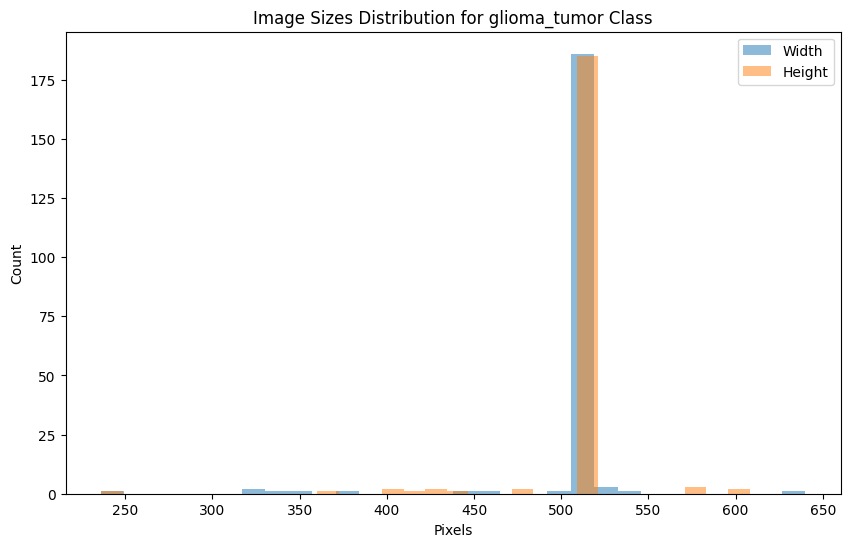

Color Modes for glioma_tumor Class: {'RGB'}


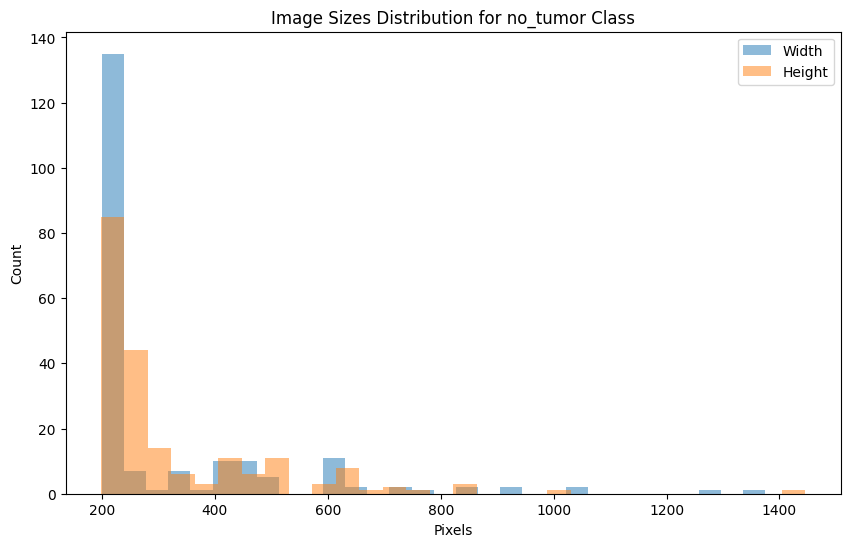

Color Modes for no_tumor Class: {'RGB'}


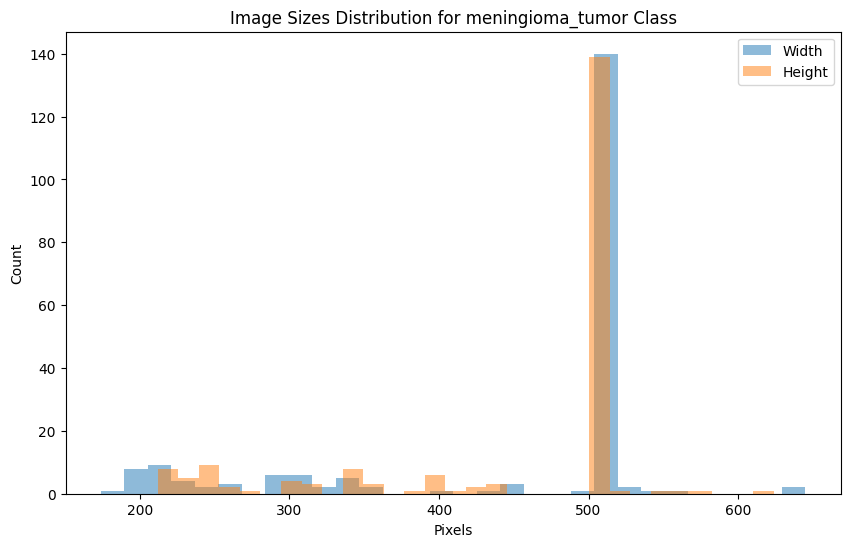

Color Modes for meningioma_tumor Class: {'RGB'}


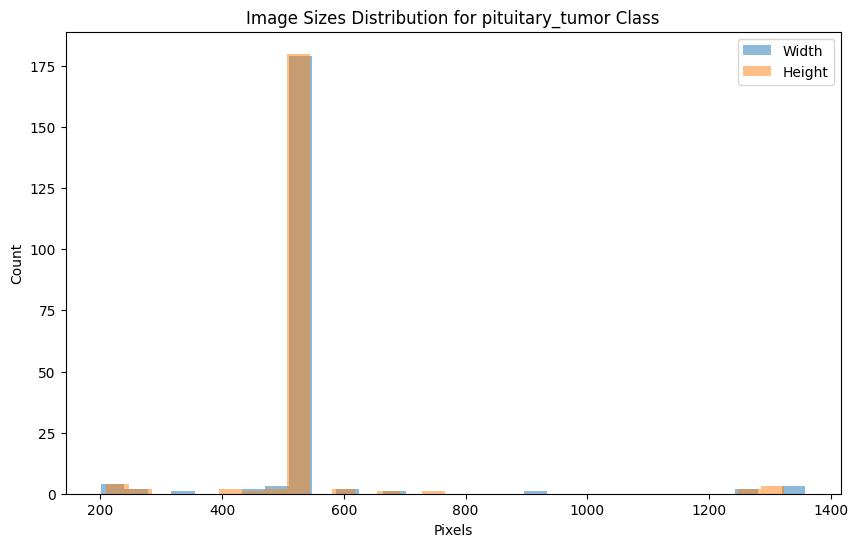

Color Modes for pituitary_tumor Class: {'RGB'}


In [ ]:
# Sample a few image paths from each class
sample_size = 200  # Number of images to sample from each class
sampled_paths = {label: BRAIN_df[BRAIN_df['labels'] == label].sample(sample_size)['filepaths'].tolist() for label in class_labels}

# Analyze image properties for each class
for label, paths in sampled_paths.items():
    analyze_image_properties(paths, label)

#### Data Preparation <a class="anchor" id="data_preparation"></a>

In [ ]:
# Define the base directory for processed images
processed_base_dir = '/content/drive/MyDrive/brain/processed_images'

# Create the directories for processed images, one for each label
for label in class_labels:
    os.makedirs(os.path.join(processed_base_dir, label), exist_ok=True)

# Function to process and save the image
def process_and_save_image(file_path, label):
    # Define the save path
    save_dir = os.path.join(processed_base_dir, label)
    file_name = os.path.basename(file_path)
    save_path = os.path.join(save_dir, file_name)

    # Process the image
    with Image.open(file_path) as img:
        resized_img = img.resize((256, 256))
        resized_img.save(save_path)

    return save_path

# Process images and save them
processed_filepaths = []
for index, row in tqdm(BRAIN_df.iterrows(), total=BRAIN_df.shape[0]):
    new_path = process_and_save_image(row['filepaths'], row['labels'])
    processed_filepaths.append(new_path)

# Add the new file paths to the DataFrame
BRAIN_df['processed_filepaths'] = processed_filepaths

# Save the DataFrame to a CSV file
processed_df_path = '/content/drive/MyDrive/brain/processed_brain_df.csv'
BRAIN_df.to_csv(processed_df_path, index=False)

  0%|          | 0/3264 [00:00<?, ?it/s]

In [ ]:
#usttekini bir kez calistirdiysan artik sadece bunu calistirman yeterli
processed_filepaths = '/content/drive/MyDrive/brain/processed_brain_df.csv'
BRAIN_df['processed_filepaths'] = processed_filepaths

In [ ]:
BRAIN_df

filepaths           labels  \
0     /content/drive/MyDrive/brain/Training/glioma_t...     glioma_tumor   
1     /content/drive/MyDrive/brain/Training/glioma_t...     glioma_tumor   
2     /content/drive/MyDrive/brain/Training/glioma_t...     glioma_tumor   
3     /content/drive/MyDrive/brain/Training/glioma_t...     glioma_tumor   
4     /content/drive/MyDrive/brain/Training/glioma_t...     glioma_tumor   
...                                                 ...              ...   
3259  /content/drive/MyDrive/brain/Testing/pituitary...  pituitary_tumor   
3260  /content/drive/MyDrive/brain/Testing/pituitary...  pituitary_tumor   
3261  /content/drive/MyDrive/brain/Testing/pituitary...  pituitary_tumor   
3262  /content/drive/MyDrive/brain/Testing/pituitary...  pituitary_tumor   
3263  /content/drive/MyDrive/brain/Testing/pituitary...  pituitary_tumor   

                                    processed_filepaths  
0     /content/drive/MyDrive/brain/processed_brain_d...  
1     /content/drive/MyDrive/brain/processed_brain_d...  
2     /content/drive/MyDrive/brain/processed_brain_d...  
3     /content/drive/MyDrive/brain/processed_brain_d...  
4     /content/drive/MyDrive/brain/processed_brain_d...  
...                                                 ...  
3259  /content/drive/MyDrive/brain/processed_brain_d...  
3260  /content/drive/MyDrive/brain/processed_brain_d...  
3261  /content/drive/MyDrive/brain/processed_brain_d...  
3262  /content/drive/MyDrive/brain/processed_brain_d...  
3263  /content/drive/MyDrive/brain/processed_brain_d...  

[3264 rows x 3 columns]

In [ ]:
# Assuming 'filepaths' and 'labels' are the columns in BRAIN_df that contain the image file paths and their corresponding labels
X = BRAIN_df['filepaths']
y = BRAIN_df['labels']

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split train data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train) # 0.25 x 0.8 = 0.2

In [ ]:
image_size = (256, 256)
num_classes = BRAIN_df['labels'].nunique()

In [ ]:
# Create a data generator for loading images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=pd.concat([X_train, y_train], axis=1),
                                                    x_col='filepaths',
                                                    y_col='labels',
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=32)
val_generator = val_datagen.flow_from_dataframe(dataframe=pd.concat([X_val, y_val], axis=1),
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(256, 256),
                                                class_mode='categorical',
                                                batch_size=32)
test_generator = test_datagen.flow_from_dataframe(dataframe=pd.concat([X_test, y_test], axis=1),
                                                  x_col='filepaths',
                                                  y_col='labels',
                                                  target_size=(256, 256),
                                                  class_mode='categorical',
                                                  batch_size=32, shuffle=False)


Found 1958 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.


### Modeling and Evaluation <a class="anchor" id="modeling_and_evaluation"></a>

##### Creating and training the ResNet model

In [ ]:
# Create the model
model = Sequential([
    ResNet50(include_top=False, pooling='avg', weights='imagenet'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use the dynamic number of classes
])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy*100:.2f}%")

21/21 [==============================] - 3s 117ms/step - loss: 0.3719 - accuracy: 0.9433
Test accuracy: 94.33%


In [ ]:
# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys(), output_dict=True)

print("Classification Report:")
print(report)

21/21 [==============================] - 4s 121ms/step
Classification Report:
{'glioma_tumor': {'precision': 0.9421052631578948, 'recall': 0.9675675675675676, 'f1-score': 0.9546666666666668, 'support': 185}, 'meningioma_tumor': {'precision': 0.9414893617021277, 'recall': 0.9414893617021277, 'f1-score': 0.9414893617021277, 'support': 188}, 'no_tumor': {'precision': 0.979381443298969, 'recall': 0.95, 'f1-score': 0.9644670050761421, 'support': 100}, 'pituitary_tumor': {'precision': 0.9662921348314607, 'recall': 0.9555555555555556, 'f1-score': 0.9608938547486034, 'support': 180}, 'accuracy': 0.9540581929555896, 'macro avg': {'precision': 0.9573170507476131, 'recall': 0.9536531212063127, 'f1-score': 0.955379222048385, 'support': 653}, 'weighted avg': {'precision': 0.9543035257025579, 'recall': 0.9540581929555896, 'f1-score': 0.9540902414941749, 'support': 653}}


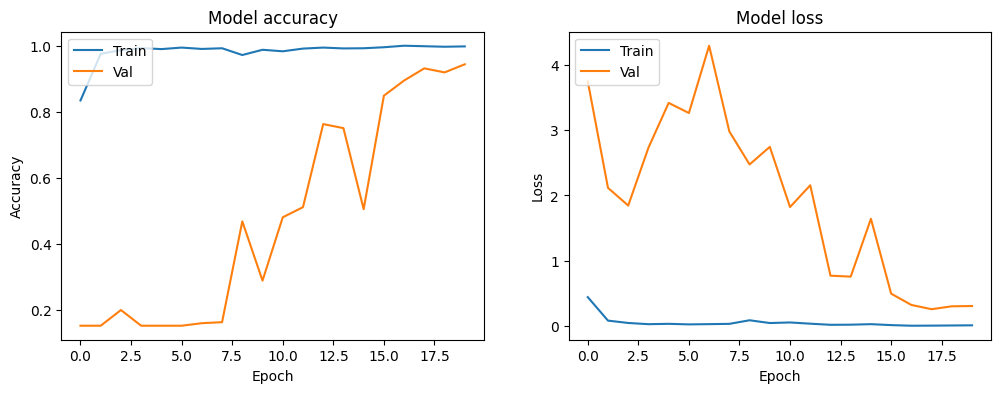

In [ ]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/kidney/resnet_model_brain.h5")

##### Creating and training the InceptionResNetV2 model

In [ ]:
model2 = Sequential([
    InceptionResNetV2(include_top=False, pooling='avg', weights='imagenet'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use the dynamic number of classes
])

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with Early Stopping
history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# Evaluate the model
loss2, accuracy2 = model2.evaluate(test_generator)
print(f"Test accuracy: {accuracy2*100:.2f}%")

21/21 [==============================] - 213s 11s/step - loss: 0.1934 - accuracy: 0.9525
Test accuracy: 95.25%


In [ ]:
# Generate predictions
predictions2 = model2.predict(test_generator)
predicted_classes2 = np.argmax(predictions2, axis=1)
true_classes2 = test_generator.classes

# Generate a classification report
report2 = classification_report(true_classes2, predicted_classes2, target_names=test_generator.class_indices.keys(), output_dict=True)

print("Classification Report:")
print(report2)

21/21 [==============================] - 6s 120ms/step
Classification Report:
{'glioma_tumor': {'precision': 0.9941176470588236, 'recall': 0.9135135135135135, 'f1-score': 0.9521126760563381, 'support': 185}, 'meningioma_tumor': {'precision': 0.9468085106382979, 'recall': 0.9468085106382979, 'f1-score': 0.9468085106382979, 'support': 188}, 'no_tumor': {'precision': 0.908256880733945, 'recall': 0.99, 'f1-score': 0.9473684210526316, 'support': 100}, 'pituitary_tumor': {'precision': 0.946236559139785, 'recall': 0.9777777777777777, 'f1-score': 0.9617486338797814, 'support': 180}, 'accuracy': 0.9525267993874426, 'macro avg': {'precision': 0.9488548993927128, 'recall': 0.9570249504823973, 'f1-score': 0.9520095604067622, 'support': 653}, 'weighted avg': {'precision': 0.9541501277556479, 'recall': 0.9525267993874426, 'f1-score': 0.9525152240031337, 'support': 653}}


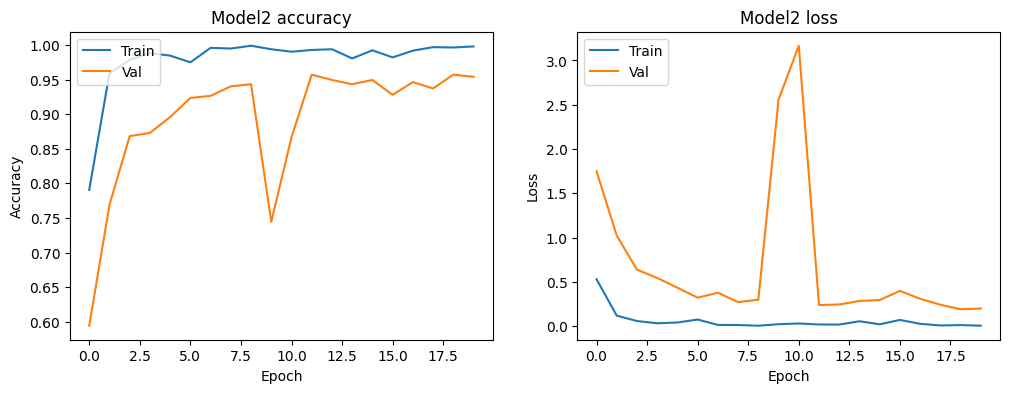

In [ ]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

In [ ]:
model2.save("/content/drive/MyDrive/brain/inc_resnet_model_brain.h5")

In [ ]:
# Load the model back from the file
model = load_model("/content/drive/MyDrive/brain/resnet_model_brain.h5")
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
# Assuming 'base_dir' is the base directory containing the folders of images
base_dir = r"/content/drive/MyDrive/brain/processed_images"
class_labels = os.listdir(base_dir)  # Assuming each subfolder represents a class

### SHAP Part <a class="anchor" id="SHAP_part"></a>

In [ ]:
def load_and_preprocess_image(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((256, 256))
    img = np.array(img, dtype=np.uint8)
    if img.ndim == 2:
        img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB
    img = preprocess_input(img)
    return img

In [ ]:
def f(x):
    return model.predict(x)

In [ ]:
def f2(x):
    return model2.predict(x)

In [ ]:
# Load and preprocess images, selecting 5 randomly from each folder
images = []
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(5, len(os.listdir(folder_path))))  # Select 5 or fewer images
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        images.append((img_path, load_and_preprocess_image(img_path)))


##### Shap application with ResNet model

In [ ]:
# Store SHAP values grouped by folder
shap_results_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 5 or fewer images
    shap_values_list = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        target_img = load_and_preprocess_image(img_path)
        target_img = np.expand_dims(target_img, axis=0)  # Ensure there is a batch dimension

        # Create the masker using the shape of the target image, dropping the batch dimension
        masker = shap.maskers.Image("inpaint_telea", target_img.shape[1:])

        # Define the explainer with the target as model input
        explainer = shap.Explainer(f, masker)

        # Explain the model's predictions using SHAP
        try:
            shap_values = explainer(target_img, max_evals=500)  # Set max_evals to limit computation
            shap_values_list.append(shap_values)
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    shap_results_by_folder[label] = shap_values_list

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step



PartitionExplainer explainer: 2it [00:24, 24.05s/it]               


1/1 [==============================] - 0s 30ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step



PartitionExplainer explainer: 2it [00:16, 16.19s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step



PartitionExplainer explainer: 2it [00:20, 20.53s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step



PartitionExplainer explainer: 2it [00:11, 11.65s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step



PartitionExplainer explainer: 2it [00:13, 13.74s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step



PartitionExplainer explainer: 2it [00:21, 21.23s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step



PartitionExplainer explainer: 2it [00:17, 17.82s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step



PartitionExplainer explainer: 2it [00:14, 14.84s/it]               


1/1 [==============================] - 0s 28ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:17, 17.83s/it]               


1/1 [==============================] - 0s 32ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:27, 27.65s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


PartitionExplainer explainer: 2it [00:14, 14.35s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:22, 22.35s/it]               


1/1 [==============================] - 0s 28ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


PartitionExplainer explainer: 2it [00:15, 15.07s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:17, 17.90s/it]               


1/1 [==============================] - 0s 31ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:18, 18.73s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:11, 11.90s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:22, 22.58s/it]               


1/1 [==============================] - 0s 30ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:25, 25.16s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


PartitionExplainer explainer: 2it [00:22, 22.57s/it]               


1/1 [==============================] - 0s 31ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:24, 24.94s/it]               


1/1 [==============================] - 0s 30ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:13, 13.52s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:19, 19.47s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


PartitionExplainer explainer: 2it [00:11, 11.40s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:19, 19.36s/it]               


1/1 [==============================] - 0s 30ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:19, 19.07s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:17, 17.93s/it]               


1/1 [==============================] - 0s 31ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:14, 14.38s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:18, 18.36s/it]               


1/1 [==============================] - 0s 30ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:15, 15.84s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:10, 10.66s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:22, 22.83s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:11, 11.25s/it]               


1/1 [==============================] - 0s 30ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:25, 25.96s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:21, 21.19s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:20, 20.98s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:15, 15.99s/it]               


1/1 [==============================] - 0s 28ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:14, 14.88s/it]               


1/1 [==============================] - 0s 30ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:10, 10.69s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:19, 19.34s/it]               


1/1 [==============================] - 0s 30ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:24, 24.44s/it]               


In [ ]:
# Display SHAP results grouped by folder
for label, shap_values_list in shap_results_by_folder.items():
    print(f"SHAP results for label: {label}")
    for shap_values in shap_values_list:
        shap.image_plot(shap_values)

Output hidden; open in https://colab.research.google.com to view.

##### Shap application with InceptionResNetV2 model

In [ ]:
# Store SHAP values grouped by folder
shap_results_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 5 or fewer images
    shap_values_list = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        target_img = load_and_preprocess_image(img_path)
        target_img = np.expand_dims(target_img, axis=0)  # Ensure there is a batch dimension

        # Create the masker using the shape of the target image, dropping the batch dimension
        masker = shap.maskers.Image("inpaint_telea", target_img.shape[1:])

        # Define the explainer with the target as model input
        explainer = shap.Explainer(f2, masker)

        # Explain the model's predictions using SHAP
        try:
            shap_values = explainer(target_img, max_evals=500)  # Set max_evals to limit computation
            shap_values_list.append(shap_values)
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    shap_results_by_folder[label] = shap_values_list

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:35, 35.66s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:21, 21.91s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:27, 27.70s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:34, 34.24s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:33, 33.17s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:34, 34.61s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:33, 33.30s/it]               


1/1 [==============================] - 0s 39ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:33, 33.84s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


PartitionExplainer explainer: 2it [00:21, 21.90s/it]               


1/1 [==============================] - 0s 47ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:19, 19.53s/it]               


1/1 [==============================] - 0s 52ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:14, 14.22s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:20, 20.74s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:32, 32.54s/it]               


1/1 [==============================] - 0s 39ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:20, 20.81s/it]               


1/1 [==============================] - 0s 39ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:22, 22.27s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:16, 16.64s/it]               


1/1 [==============================] - 0s 39ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


PartitionExplainer explainer: 2it [00:14, 14.75s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:25, 25.27s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


PartitionExplainer explainer: 2it [00:28, 28.19s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:18, 18.77s/it]               


1/1 [==============================] - 0s 51ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


PartitionExplainer explainer: 2it [00:33, 33.98s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:27, 27.35s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:34, 34.82s/it]               


1/1 [==============================] - 0s 47ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:18, 18.34s/it]               


1/1 [==============================] - 0s 39ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:34, 34.31s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:18, 18.03s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


PartitionExplainer explainer: 2it [00:35, 35.19s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


PartitionExplainer explainer: 2it [00:30, 30.99s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:26, 26.53s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:16, 16.01s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:15, 15.48s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:34, 34.32s/it]               


1/1 [==============================] - 0s 49ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:25, 25.83s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:15, 15.67s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:32, 32.86s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:32, 32.68s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:31, 31.41s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:10, 10.30s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:23, 23.21s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:34, 34.92s/it]               


In [ ]:
# Display SHAP results grouped by folder
for label, shap_values_list in shap_results_by_folder.items():
    print(f"SHAP results for label: {label}")
    for shap_values in shap_values_list:
        shap.image_plot(shap_values)

Output hidden; open in https://colab.research.google.com to view.

### LIME Part<a class="anchor" id="LIME_part"></a>

In [ ]:
# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))  # InceptionV3 expects 299x299 input
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
def model_predict(img_batch):
    return model.predict(img_batch)

In [ ]:
def model_predict2(img_batch):
    return model2.predict(img_batch)

##### Lime application with ResNet model

In [ ]:

# Create a LIME explainer object
explainer = lime_image.LimeImageExplainer()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 10 or fewer images
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain a prediction from the model
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)

            # Get image and mask for the top prediction
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


In [ ]:
# Display explanations grouped by folder
for label, explanations in explanations_by_folder.items():
    print(f"Explanations for label: {label}")
    for temp, mask in explanations:
        plt.figure(figsize=(8, 8))
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

##### Lime application with InceptionResNetV2 model

In [ ]:

# Create a LIME explainer object
explainer = lime_image.LimeImageExplainer()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 10 or fewer images
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain a prediction from the model
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict2, top_labels=5, hide_color=0, num_samples=1000)

            # Get image and mask for the top prediction
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


In [ ]:
# Display explanations grouped by folder
for label, explanations in explanations_by_folder.items():
    print(f"Explanations for label: {label}")
    for temp, mask in explanations:
        plt.figure(figsize=(8, 8))
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

### GRAD-CAM Part <a class="anchor" id="GRAD-CAM_part"></a>

In [ ]:
# Assuming you have a 'model_predict' function and 'preprocess_input' ready
def load_and_preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')  # Ensure images are RGB
    img = img.resize((224, 224))  # Adjust size to fit model expected input
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Apply model-specific preprocessing
    return img

In [ ]:
def model_predict(image_array):
    # Convert image array to a suitable format your model expects, if not already
    # Return prediction probabilities
    return model.predict(image_array)

In [ ]:
def model_predict2(image_array):
    # Convert image array to a suitable format your model expects, if not already
    # Return prediction probabilities
    return model2.predict(image_array)

##### Grad-Cam application with ResNet model

In [ ]:
# Create a GradCAM explainer object
explainer = grad_image.gradCAM()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting up to 10 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain the model prediction
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

# Optionally, visualize the explanations
for label, explanation_data in explanations_by_folder.items():
    print(f"Label: {label}")
    for i, (temp, mask) in enumerate(explanation_data):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(temp)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='RdBu')
        plt.title('Explanation Mask')
        plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

##### Grad-Cam application with InceptionResNetV2 model

In [ ]:
# Create a GradCam explainer object
explainer = grad_image.gradCAM()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting up to 10 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain the model prediction
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict2, top_labels=5, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

# Optionally, visualize the explanations
for label, explanation_data in explanations_by_folder.items():
    print(f"Label: {label}")
    for i, (temp, mask) in enumerate(explanation_data):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(temp)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='RdBu')
        plt.title('Explanation Mask')
        plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Further Analysis <a class="anchor" id="further_analysis"></a>
#### Cropping the images throughout their edges and training the models with them.

In [ ]:
def crop_largest_contour(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    _, thresholded = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_image = image_rgb[y:y+h, x:x+w]
    return cropped_image

In [ ]:
def process_images(input_dir, output_dir):
    categories = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
    for category in categories:
        cat_input_path = os.path.join(input_dir, category)
        cat_output_path = os.path.join(output_dir, category)
        os.makedirs(cat_output_path, exist_ok=True)
        images = os.listdir(cat_input_path)
        for filename in tqdm(images, desc=f"Processing {category}"):
            input_path = os.path.join(cat_input_path, filename)
            output_path = os.path.join(cat_output_path, filename)
            cropped_image = crop_largest_contour(input_path)
            resized_image = cv2.resize(cropped_image, (256, 256))
            save_img(output_path, resized_image)

In [ ]:
# Define your input and output directories
input_directory = '/content/drive/MyDrive/brain/processed_images'
output_directory = '/content/drive/MyDrive/brain/cropped_processed_images'

# Process all images
process_images(input_directory, output_directory)

Processing glioma_tumor:   0%|          | 0/926 [00:00<?, ?it/s]

Processing no_tumor:   0%|          | 0/396 [00:00<?, ?it/s]

Processing meningioma_tumor:   0%|          | 0/937 [00:00<?, ?it/s]

Processing pituitary_tumor:   0%|          | 0/901 [00:00<?, ?it/s]

In [ ]:
def load_data(directory):
    images = []
    labels = []
    label_dict = {'glioma_tumor': 0, 'no_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}

    for label, idx in label_dict.items():
        path = os.path.join(directory, label)
        files = os.listdir(path)
        for file in tqdm(files, desc=f"Loading {label}"):
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (256, 256))
            images.append(img)
            labels.append(idx)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(label_dict))
    return images, labels

In [ ]:
# Define your input directory
input_directory = '/content/drive/MyDrive/brain/cropped_processed_images'
images, labels = load_data(input_directory)

Loading glioma_tumor:   0%|          | 0/926 [00:00<?, ?it/s]

Loading no_tumor:   0%|          | 0/396 [00:00<?, ?it/s]

Loading meningioma_tumor:   0%|          | 0/937 [00:00<?, ?it/s]

Loading pituitary_tumor:   0%|          | 0/901 [00:00<?, ?it/s]

In [ ]:
# First, split into a temporary training and a final test set
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Then split the temporary training set into the actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [ ]:
def create_model():

    model = Sequential([
      InceptionResNetV2(include_top=False, pooling='avg', weights='imagenet'),
      Flatten(),
      Dense(1024, activation='relu'),
      Dense(4, activation='softmax')  # Assuming 4 classes as per your dataset
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=TqdmCallback(verbose=1))


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
60/60 [==============================] - 96s 365ms/step - loss: 0.6416 - accuracy: 0.7790 - val_loss: 3.1673 - val_accuracy: 0.3908
Epoch 2/10
60/60 [==============================] - 18s 305ms/step - loss: 0.3296 - accuracy: 0.8877 - val_loss: 0.6984 - val_accuracy: 0.7911
Epoch 3/10
60/60 [==============================] - 18s 304ms/step - loss: 0.1827 - accuracy: 0.9393 - val_loss: 0.4443 - val_accuracy: 0.8813
Epoch 4/10
60/60 [==============================] - 18s 303ms/step - loss: 0.1485 - accuracy: 0.9557 - val_loss: 2.1093 - val_accuracy: 0.6028
Epoch 5/10
60/60 [==============================] - 18s 305ms/step - loss: 0.1584 - accuracy: 0.9504 - val_loss: 0.3725 - val_accuracy: 0.8813
Epoch 6/10
60/60 [==============================] - 18s 306ms/step - loss: 0.1896 - accuracy: 0.9362 - val_loss: 0.2603 - val_accuracy: 0.9114
Epoch 7/10
60/60 [==============================] - 18s 306ms/step - loss: 0.0973 - accuracy: 0.9689 - val_loss: 0.4342 - val_accuracy: 0.8703

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

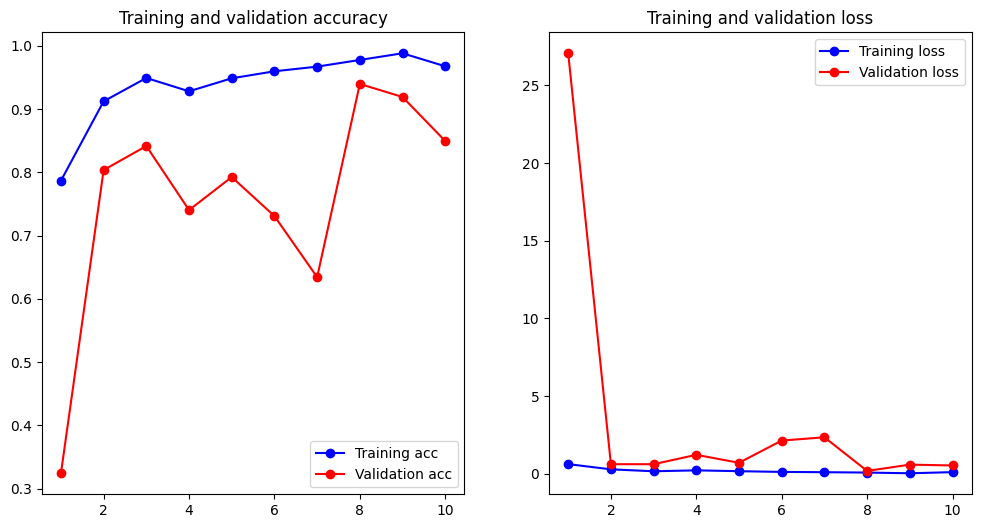

20/20 [==============================] - 5s 85ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.65      0.78       203
        no_tumor       0.81      0.87      0.84        71
meningioma_tumor       0.79      0.99      0.88       192
 pituitary_tumor       0.81      0.87      0.84       166

        accuracy                           0.84       632
       macro avg       0.85      0.85      0.84       632
    weighted avg       0.86      0.84      0.83       632



In [ ]:
label_dict = {'glioma_tumor': 0, 'no_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print(classification_report(y_true_classes, y_pred_classes, target_names=list(label_dict.keys())))

plot_history(history)
evaluate_model(model, X_test, y_test)

In [ ]:
# Assuming 'base_dir' is the base directory containing the folders of images
base_dir = r"/content/drive/MyDrive/brain/cropped_processed_images"
class_labels = os.listdir(base_dir)  # Assuming each subfolder represents a class

#### Trying SHAP

In [ ]:
# Load and preprocess images, selecting 5 randomly from each folder
images = []
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(5, len(os.listdir(folder_path))))  # Select 5 or fewer images
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        images.append((img_path, load_and_preprocess_image(img_path)))

In [ ]:
# Store SHAP values grouped by folder
shap_results_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 5 or fewer images
    shap_values_list = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        target_img = load_and_preprocess_image(img_path)
        target_img = np.expand_dims(target_img, axis=0)  # Ensure there is a batch dimension

        # Create the masker using the shape of the target image, dropping the batch dimension
        masker = shap.maskers.Image("inpaint_telea", target_img.shape[1:])

        # Define the explainer with the target as model input
        explainer = shap.Explainer(f, masker)

        # Explain the model's predictions using SHAP
        try:
            shap_values = explainer(target_img, max_evals=500)  # Set max_evals to limit computation
            shap_values_list.append(shap_values)
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    shap_results_by_folder[label] = shap_values_list

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


PartitionExplainer explainer: 2it [00:21, 21.65s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:21, 21.06s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:21, 21.05s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:20, 20.79s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:19, 19.86s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:19, 19.86s/it]               


1/1 [==============================] - 0s 39ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:21, 21.78s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:19, 19.22s/it]               


1/1 [==============================] - 0s 50ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:19, 19.54s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:22, 22.22s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:19, 19.36s/it]               


1/1 [==============================] - 0s 39ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:23, 23.48s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:21, 21.04s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:20, 20.88s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:20, 20.45s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:19, 19.56s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:19, 19.85s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:21, 21.29s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:20, 20.13s/it]               


1/1 [==============================] - 0s 39ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:19, 19.86s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:20, 20.52s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:24, 24.40s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:20, 20.65s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:21, 21.97s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:20, 20.69s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:21, 21.37s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:23, 23.47s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:21, 21.37s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:22, 22.55s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:20, 20.35s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:21, 21.63s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:21, 21.44s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:19, 19.93s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:20, 20.49s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:17, 17.57s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:22, 22.16s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:21, 21.95s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:18, 18.10s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:19, 19.64s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:19, 19.19s/it]               


In [ ]:
# Display SHAP results grouped by folder
for label, shap_values_list in shap_results_by_folder.items():
    print(f"SHAP results for label: {label}")
    for shap_values in shap_values_list:
        shap.image_plot(shap_values)

Output hidden; open in https://colab.research.google.com to view.

#### Trying LIME


In [ ]:

# Create a LIME explainer object
explainer = lime_image.LimeImageExplainer()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 10 or fewer images
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain a prediction from the model
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)

            # Get image and mask for the top prediction
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


In [ ]:
# Display explanations grouped by folder
for label, explanations in explanations_by_folder.items():
    print(f"Explanations for label: {label}")
    for temp, mask in explanations:
        plt.figure(figsize=(8, 8))
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Trying GRAD-Cam


In [ ]:
# Create a Grad-Cam explainer object
explainer = grad_image.gradCAM()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting up to 10 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain the model prediction
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


In [ ]:

# Optionally, visualize the explanations
for label, explanation_data in explanations_by_folder.items():
    print(f"Label: {label}")
    for i, (temp, mask) in enumerate(explanation_data):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(temp)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='RdBu')
        plt.title('Explanation Mask')
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

## References<a class="anchor" id="references"></a>


https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Image%20Multi%20Class.html
https://shap.readthedocs.io/en/latest/generated/shap.maskers.Image.html
https://www.datacamp.com/tutorial/explainable-ai-understanding-and-trusting-machine-learning-models
https://christophm.github.io/interpretable-ml-book/lime.html4
https://towardsdatascience.com/lime-explain-machine-learning-predictions-af8f18189bfe
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
https://www.mathworks.com/help/deeplearning/ug/gradcam-explains-why.html
https://www.analyticsvidhya.com/blog/2023/12/grad-cam-in-deep-learning/#:~:text=Grad%2DCAM%20stands%20for%20Gradient,prediction%20of%20a%20particular%20class.



**Disclaimer!** <font color='grey'>This notebook was prepared by <Sare Naz Bayraktutan and Tuncer Sivri> as a term project for the *BBM467 - Data Intensive Applications* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8).
</font>